In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

#keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [ ]:
print(os.listdir('/content/drive/MyDrive/'))

['Getting started.pdf', 'Classroom', 'Screenshot_20230601_221410_Chrome.png', 'Colab Notebooks', 'Debajyoti_Dutta 12022002022144 passport.png', 'Certificates_4th_sem.pdf', 'AssignmentPW.pdf', 'services.xlsx', 'Screenshot_20240829_173438_Chrome.png', 'SIH_2024.pdf', 'Debajyoti_Dutta_Medical_Report .pdf', '20240919_225340.jpg', 'Resume_Debajyoti ', 'Resume.pdf', 'movie_recommender_system.pdf', 'movies12345.pdf', 'DebajyotiDuttaResume (1).pdf', '20250207_204142 (1).pdf', 'Screenshot_20250207_204300_Chrome (1).pdf', '20250207_204154 (1).pdf', '20250207_204130 (1).pdf', '20250207_204107 (1) (1).pdf', 'DebajyotiDuttaResume.pdf', 'MRI_Images']


In [ ]:
#Directories for training and testing the data
train_dir = '/content/drive/MyDrive/MRI_Images/Training/'
test_dir = '/content/drive/MyDrive/MRI_Images/Testing/'

#load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

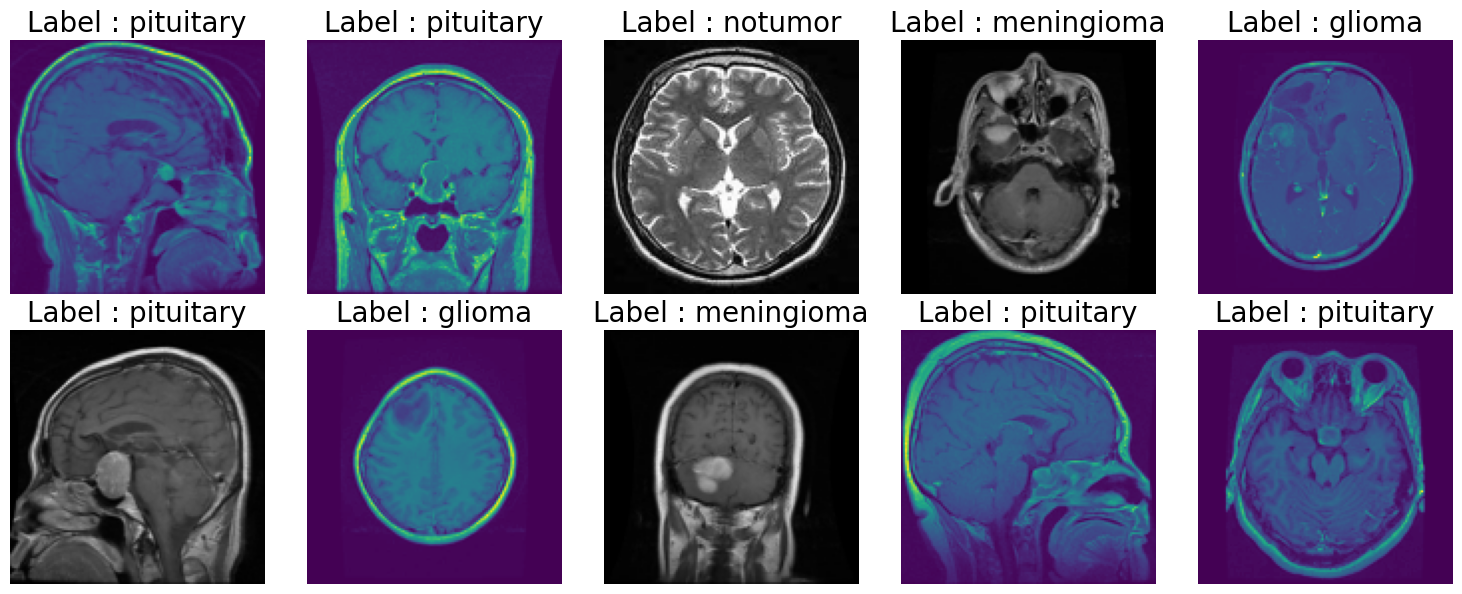

In [ ]:
#Data Visualization
import random
import matplotlib.pyplot as plt

#select random indicies for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

#Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize = (15, 6))
axes= axes.ravel()

#loop through random indices and display images
for i, idx in enumerate(random_indices):
  img_path = train_paths[idx];
  img = Image.open(img_path)
  img = img.resize((128, 128))

  #Display images
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f"Label : {train_labels[idx]}", fontsize = 20)

plt.tight_layout()
plt.show()

In [ ]:
from enum import unique
#Image Preprocessing
#Image Augmentation Function
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0
  return image

#Load images and apply augmentation
def open_images(paths):
  images = []
  for path in paths:
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    IMG = augment_image(img)
    images.append(IMG)
  return np.array(images)

#Encoder labels (COnvert label names to integers)
def encode_labels(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)

#Data generator for batching
def datagen(paths, labels, batch_size = 12, epochs = 1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i: i + batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i : i + batch_size]
      batch_labels = encode_labels(batch_labels)
      yield batch_images, batch_labels

In [ ]:
#Model Architecture (128, 128, 3)
IMAGE_SIZE = 128
base_model = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False,weights = 'imagenet')

#Freeze all layers of the VGG16
for layer in base_model.layers:
  layer.trainable = False

# Set only the last few layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build Mode
model = Sequential()
model.add(Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))) #Input layer
model.add(base_model) #VGG16
model.add(Flatten()) #Flatten layer
model.add(Dropout(0.3)) #Dropout layer (drop randomly 30% layers)

model.add(Dense(128, activation = 'relu')) # Dense layer
model.add(Dropout(0.2)) # Dropout layer

model.add(Dense(len(os.listdir(train_dir)), activation = 'softmax')) #Output layer

#Compile the model
model.compile(optimizer = Adam(learning_rate= 0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

#Parameters
batch_size = 20
steps = int(len(train_paths)/ batch_size)
epochs = 5

#train model
history = model.fit(datagen(train_paths, train_labels, batch_size = batch_size, epochs = epochs),
                    epochs = epochs,steps_per_epoch = steps)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2597s 9s/step - loss: 0.6482 - sparse_categorical_accuracy: 0.7387
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1420s 5s/step - loss: 0.2634 - sparse_categorical_accuracy: 0.9005
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1411s 5s/step - loss: 0.1874 - sparse_categorical_accuracy: 0.9358
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1415s 5s/step - loss: 0.1341 - sparse_categorical_accuracy: 0.9503
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1408s 5s/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9678


<Figure size 800x400 with 0 Axes>

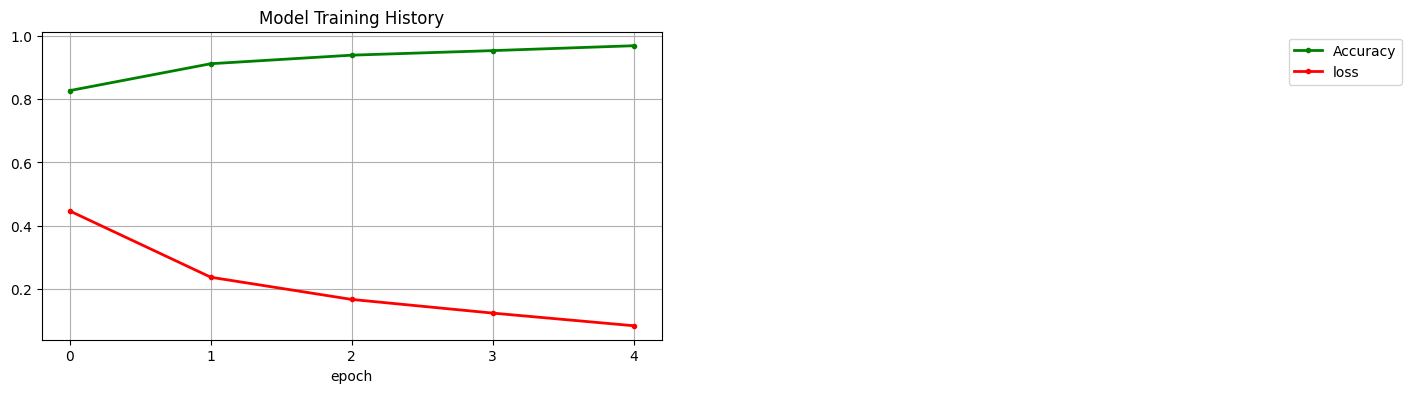

In [ ]:
plt.figure(figsize=(8, 4))
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth = 2)
plt.plot(history.history['loss'], '.r-', linewidth = 2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'loss'], loc = 'upper left', bbox_to_anchor = (2,1))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

test_images = open_images(test_paths)
test_labels_encoded = encode_labels(test_labels)
test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis = 1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 270s 7s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       306
           1       0.99      0.79      0.88       300
           2       0.99      0.98      0.99       405
           3       0.99      0.70      0.82       300

    accuracy                           0.87      1311
   macro avg       0.91      0.86      0.87      1311
weighted avg       0.91      0.87      0.88      1311



Confusion Matrix
[[304   0   1   1]
 [ 64 236   0   0]
 [  7   0 396   2]
 [ 86   3   1 210]]


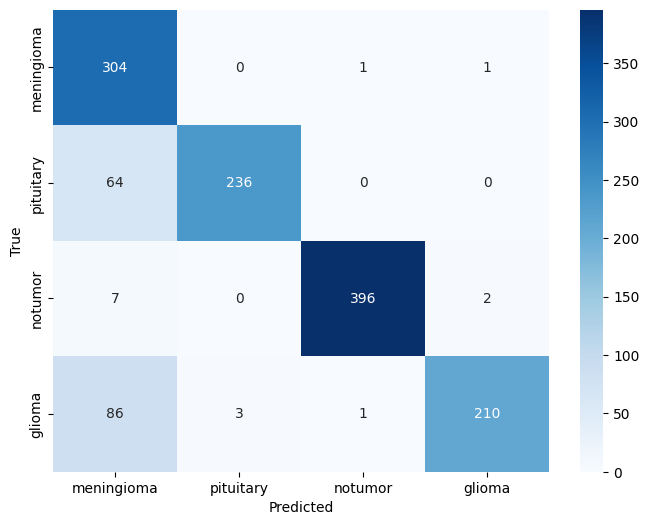

In [ ]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis = 1))
print("Confusion Matrix")
print(conf_matrix)

plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

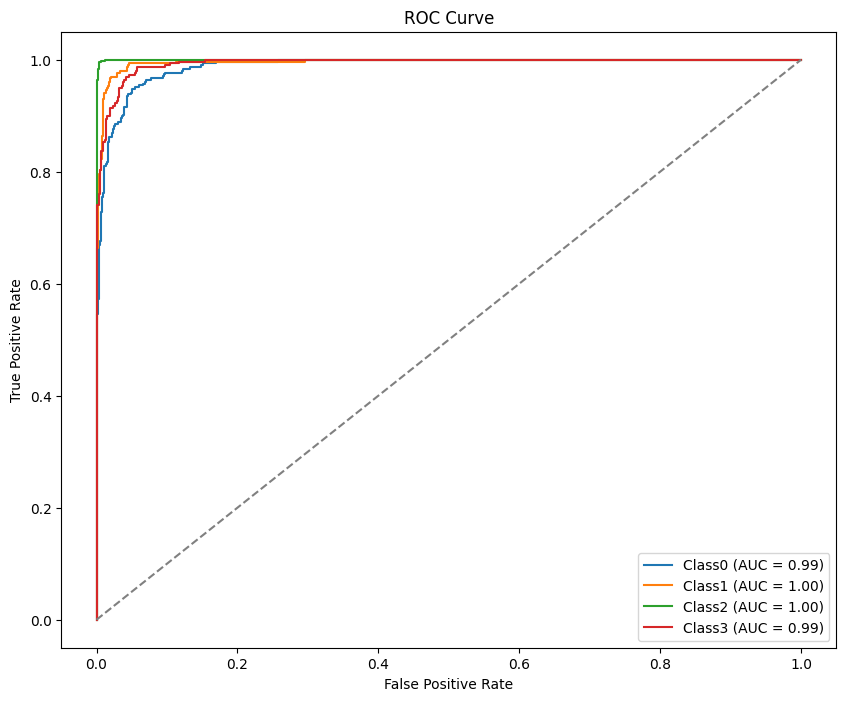

In [ ]:
#ROC Curve and AUC
test_labels_bin = label_binarize(test_labels_encoded, classes = np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

#compute ROC and ROC AUC for each curve
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
  fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

#plot ROC curve
plt.figure(figsize = (10, 8))
for i in range(len(os.listdir(train_dir))):
  plt.plot(fpr[i], tpr[i], label = f'Class{i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1], [0, 1], linestyle = '--', color = 'gray')
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
#Load the trained model
model = load_model('model.h5')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model):
  try:
    #load image
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis = 0)

    #prediction
    predictions = model.predict(img_array) #0 = 0.90, 1 = 0.60, 2 = 0.99, 3 = 0.40
    predicted_class_index = np.argmax(predictions)
    confidence_score = np.max(predictions, axis = 1)[0]

    #determine the class
    if class_labels[predicted_class_index] == 'notumor':
      result =  "No Tumor"
    else:
      result = f"Prediction: {class_labels[predicted_class_index]}"
      #display
      plt.imshow(load_img(img_path))
      plt.axis('off')
      plt.title(f"{result}(Confidence) {confidence_score * 100:.2f}%")
      plt.show()

  except Exception as e:
    print("Error processing the image", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


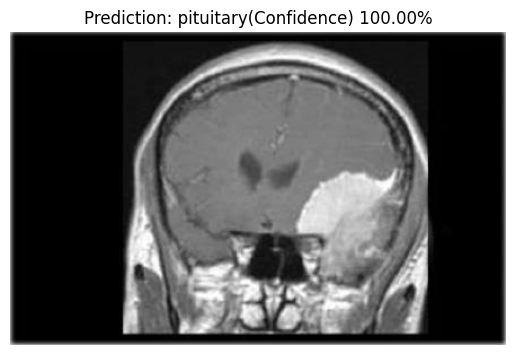

In [ ]:
#example
image_path = '/content/drive/MyDrive/MRI_Images/Testing/meningioma/Te-meTr_0000.jpg'
detect_and_display(image_path, model)

In [ ]:
image_path = '/content/drive/MyDrive/MRI_Images/Testing/glioma/Te-glTr_0000.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


In [ ]:
image_path = '/content/drive/MyDrive/MRI_Images/Testing/notumor/Te-noTr_0000.jpg'
detect_and_display(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
